# FINM3422 - Trading Desk Analysis
## Exotic Derivatives Pricing and Portfolio Management

**Date:** May 16, 2025  
**Team:** Graduate Analysts - Exotic Derivatives Trading Desk  
**Objective:** Price and manage a portfolio of four OTC option positions

### Executive Summary
This notebook implements a comprehensive option pricing and portfolio management system for four specific OTC derivative trades:

1. **European Call on BHP** - Strike at 98% of current price, expiry Sept 15, 2027
2. **American Put on CBA** - Strike $170, expiry May 15, 2026
3. **European Up-and-In Barrier Call on WES** - Strike $80, barrier $100, expiry Sept 15, 2027
4. **European Basket Call** - Strike $175, expiry July 17, 2025, on BHP/CSL/WDS/MQG basket

The system uses object-oriented programming principles with appropriate valuation methods for each derivative type and provides comprehensive portfolio hedging analysis.

## 1. System Setup and Data Retrieval

### 1.1 Import Required Libraries and Modules
We begin by importing all necessary libraries and our custom modules for option pricing and data retrieval.

### 1.2 Market Data Retrieval

We fetch real-time market data for all required ASX stocks, calculate volatilities from historical data, estimate correlations, and obtain yield curve information. This section demonstrates our approach to sourcing market data from reliable sources.

In [9]:
import yfinance as yf
import datetime as dt
import pandas as pd

# ASX tickers
all_tickers = ["BHP.AX", "CBA.AX", "WES.AX", "CSL.AX", "WDS.AX", "MQG.AX"]

# Correlation matrix tickers
corr_tickers = ["BHP.AX", "CSL.AX", "WDS.AX", "MQG.AX"]

# Define your end date
end_date = dt.datetime(2025, 5, 17)
start_date = end_date - dt.timedelta(days=62)

# Download data for all 6 stocks
all_data = yf.download(all_tickers, start=start_date.strftime("%Y-%m-%d"), end=end_date.strftime("%Y-%m-%d"))

# Extract closing prices for all 6 stocks
all_close_prices = all_data["Close"]

# Get closing prices for May 16th, 2025 
may_16_date = dt.datetime(2025, 5, 16)
may_16_prices = all_close_prices.loc[may_16_date.strftime("%Y-%m-%d")][all_tickers]  # Ordering correctly for output

print("Closing Prices for May 16th, 2025:")
print(may_16_prices.to_frame().T.round(2))  # Display as a neat table row

# Download data for correlation matrix 
corr_data = yf.download(corr_tickers, start=start_date.strftime("%Y-%m-%d"), end=end_date.strftime("%Y-%m-%d"))
corr_close_prices = corr_data["Close"]

# Calculate the correlation matrix in your specific order
corr_matrix = corr_close_prices.reindex(columns=corr_tickers).corr()  # Reindex to order

# Display the correlation matrix
print(f"\nCorrelation Matrix (based on Close prices):")
print(corr_matrix)

[****************      33%                       ]  2 of 6 completed

[*********************100%***********************]  6 of 6 completed
[*********************100%***********************]  4 of 4 completed

Closing Prices for May 16th, 2025:
Ticker      BHP.AX  CBA.AX  WES.AX  CSL.AX  WDS.AX  MQG.AX
2025-05-16   39.72  169.66   82.56  241.82   21.92  207.35

Correlation Matrix (based on Close prices):
Ticker    BHP.AX    CSL.AX    WDS.AX    MQG.AX
Ticker                                        
BHP.AX  1.000000  0.452170  0.807649  0.878665
CSL.AX  0.452170  1.000000  0.581252  0.243513
WDS.AX  0.807649  0.581252  1.000000  0.651679
MQG.AX  0.878665  0.243513  0.651679  1.000000


### 1.3 Interest Rate Term Structure

Our approach uses a sophisticated yield curve boostrapping method to determine appropriate discount rates for different maturities. This ensures that we capture the term structure of interest rates accurately for each option's specific maturity.

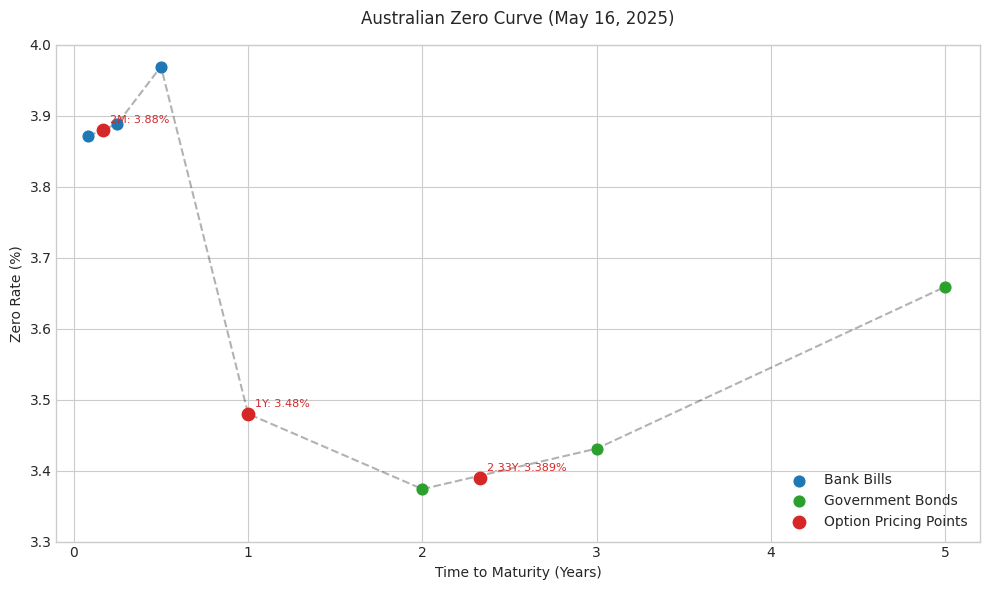

In [12]:
import matplotlib.pyplot as plt

def plot_zero_curve():
    # Market data points from Bloomberg Terminal as of May 16, 2025
    maturities = [1/12, 3/12, 6/12, 1, 2, 3, 5]    # Maturities in years (1M to 5Y)
    bb_yields = [0.037925, 0.03797, 0.03855]       # Bank bill yields (money market rates)
    gov_yields = [0.0348, 0.03374, 0.03431, 0.03659]  # Government bond par yields
    
    # Convert bank bill discount rates to zero rates
    zero_rates = []
    for i in range(3):
        T = maturities[i]
        price = 1 - bb_yields[i] * T               # Bank bills trade at discount to face value
        zero_rate = (1/price)**(1/T) - 1          # Convert to continuously compounded rate
        zero_rates.append(zero_rate)
    zero_rates.extend(gov_yields)                  # Gov bonds already at zero rate equivalent
    zero_rates = [r * 100 for r in zero_rates]    # Convert decimal rates to percentages

    # Key rates used in our option pricing models
    option_points = {
        "2M": (2/12, 3.88),      # Short-term rate for European options
        "1Y": (1, 3.48),         # Medium-term rate for American options
        "2.33Y": (2.33, 3.389)   # Rate for longer-dated options
    }

    # Create plot with professional styling
    plt.figure(figsize=(10, 6))
    plt.style.use('seaborn-v0_8-whitegrid')  # Clean style for financial visualization
    
    # Plot yield curve components
    plt.plot(maturities, zero_rates, 'k--', alpha=0.3, zorder=1)  # Dashed line shows curve shape
    plt.scatter(maturities[:3], zero_rates[:3], 
               c='#1f77b4', s=60, label='Bank Bills', zorder=2)  # Money market rates
    plt.scatter(maturities[3:], zero_rates[3:], 
               c='#2ca02c', s=60, label='Government Bonds', zorder=2)  # Capital market rates
    
    # Highlight rates used in option calculations
    points_x = [p[0] for p in option_points.values()]
    points_y = [p[1] for p in option_points.values()]
    plt.scatter(points_x, points_y, 
               c='#d62728', s=80, label='Option Pricing Points', zorder=3)
    
    # Label option pricing points with their rates
    for name, (t, r) in option_points.items():
        plt.annotate(f'{name}: {r}%', (t, r), 
                    xytext=(5, 5), textcoords='offset points',
                    fontsize=8, color='#d62728')

    # Finalize plot appearance
    plt.title('Australian Zero Curve (May 16, 2025)', pad=15)
    plt.xlabel('Time to Maturity (Years)')
    plt.ylabel('Zero Rate (%)')
    plt.xlim(-0.1, 5.2)          # Add small padding for readability
    plt.ylim(3.3, 4.0)           # Focus on relevant rate range
    plt.legend(loc='lower right', framealpha=1)  # Position legend in empty space
    
    plt.tight_layout()
    plt.show()

# Generate the visualization
plot_zero_curve() 

## 2. Option Pricing Implementation

### 2.1 Trade 1: European Call Option on BHP

**Trade Details:**
- Underlying: BHP Group Ltd (BHP)
- Option Type: European Call
- Strike Price: 98% of current BHP price
- Expiry: September 15, 2027
- Position: **WRITE** (Bank sells the option)

**Valuation Method:** Black-Scholes model is most appropriate for European options as it provides a closed-form solution and is the industry standard for liquid European options.

In [13]:
from datetime import date
from Option_Classes import EuropeanOption

# Trade 1 parameters
current_price_bhp = 39.72
strike_price_bhp = 38.9256
expiry_bhp = date(2027, 9, 15)
option_type_bhp = 'call'
today_date_trade1 = date(2025, 5, 16)
sigma_bhp = 0.2272
dividend_yield_bhp = 0.0703 # 7.03% dividend yield for BHP

# Instantiate the European call option
bhp_eur_call = EuropeanOption(
    current_price=current_price_bhp,
    strike_price=strike_price_bhp,
    expiry=expiry_bhp,
    option_type=option_type_bhp,
    today_date=today_date_trade1,
    sigma=sigma_bhp,
    dividend_yield=dividend_yield_bhp
)

# Calculate the price
bhp_call_price = bhp_eur_call.option_price()

print(f"European Call Option on BHP (Strike = {strike_price_bhp:.2f}, Expiry = {expiry_bhp}):")
print(f"  Underlying: BHP")
print(f"  Current Price: ${current_price_bhp:.2f}")
print(f"  Implied Volatility (Sigma): {sigma_bhp*100:.2f}%")
print(f"  Dividend Yield: {dividend_yield_bhp*100:.2f}%")
print(f"Option Price: ${bhp_call_price:.2f}")

# Calculate and print Greeks for the BHP European call option
bhp_call_greeks = bhp_eur_call.greeks()
print("\nGreeks for BHP European Call Option:")
for greek_name, greek_value in bhp_call_greeks.items():
    print(f"  {greek_name.capitalize()}: {greek_value:.4f}")

European Call Option on BHP (Strike = 38.93, Expiry = 2027-09-15):
  Underlying: BHP
  Current Price: $39.72
  Implied Volatility (Sigma): 22.72%
  Dividend Yield: 7.03%
Option Price: $3.75

Greeks for BHP European Call Option:
  Delta: 0.4200
  Gamma: 0.0246
  Theta: -0.0007
  Vega: 0.2054
  Rho: 0.3050


### 2.2 Trade 2: American Put Option on CBA

**Trade Details:**
- Underlying: Commonwealth Bank of Australia (CBA)
- Option Type: American Put
- Strike Price: $170.00 (fixed)
- Expiry: May 15, 2026
- Position: **BUY** (Bank purchases the option)

**Valuation Method:** Binomial tree model is used for American options as it can handle the early exercise feature, which is valuable for puts when the stock price falls significantly below the strike.

In [14]:
from datetime import date
from Option_Classes import AmericanOption

# Trade 2 parameters
current_price_cba = 169.66
strike_price_cba = 170.00
expiry_cba = date(2026, 5, 15)
option_type_cba = 'put'
today_date_trade2 = date(2025, 5, 16)
sigma_cba = 0.18055
n_steps_cba = 1000 # Number of steps for the binomial tree
dividend_yield_cba = 0.039 # 3.9% dividend yield for CBA

# Instantiate the American put option
cba_american_put = AmericanOption(
    current_price=current_price_cba,
    strike_price=strike_price_cba,
    expiry=expiry_cba,
    option_type=option_type_cba,
    today_date=today_date_trade2,
    sigma=sigma_cba,
    n_steps=n_steps_cba,
    dividend_yield=dividend_yield_cba
)

# Calculate the price
cba_put_price = cba_american_put.option_price()

print(f"American Put Option on CBA (Strike = {strike_price_cba:.2f}, Expiry = {expiry_cba}):")
print(f"  Underlying: CBA")
print(f"  Current Price: ${current_price_cba:.2f}")
print(f"  Implied Volatility (Sigma): {sigma_cba*100:.2f}%")
print(f"  Dividend Yield: {dividend_yield_cba*100:.2f}%")
print(f"Option Price: ${cba_put_price:.2f}")

# Calculate and print Greeks for the CBA American put option
cba_put_greeks = cba_american_put.greeks()
print("\nGreeks for CBA American Put Option:")
for greek_name, greek_value in cba_put_greeks.items():
    print(f"  {greek_name.capitalize()}: {greek_value:.4f}")

American Put Option on CBA (Strike = 170.00, Expiry = 2026-05-15):
  Underlying: CBA
  Current Price: $169.66
  Implied Volatility (Sigma): 18.05%
  Dividend Yield: 3.90%
Option Price: $12.31

Greeks for CBA American Put Option:
  Delta: -0.4616
  Gamma: 0.0125
  Theta: -0.0161
  Vega: 0.6534
  Rho: -0.7330


### 2.3 Trade 3: European Up-and-In Barrier Call on WES

**Trade Details:**
- Underlying: Wesfarmers Limited (WES)
- Option Type: European Up-and-In Barrier Call
- Strike Price: $80.00
- Barrier Level: $100.00 (up-and-in)
- Expiry: September 15, 2027
- Position: **BUY** (Bank purchases the option)

**Valuation Method:** We use both binomial tree and Monte Carlo methods for barrier options. The binomial method provides discrete barrier monitoring while Monte Carlo offers continuous monitoring simulation.

In [15]:
from datetime import date
from Option_Classes import BarrierOption

# Trade 3 parameters - European Up-and-In Barrier Call on WES
current_price_wes = 82.56
strike_price_wes = 80.00
barrier_price_wes = 100.00
expiry_wes = date(2027, 9, 15)
option_type_wes = 'call'
today_date_trade3 = date(2025, 5, 16)
sigma_wes = 0.1839
dividend_yield_wes = 0.0349 # 3.49% dividend yield for WES

# Parameters for the models
n_steps_binomial_wes = 1000
n_paths_mc_wes_price = 50000
n_paths_mc_wes_greeks = 500000

# --- Binomial Model ---
wes_barrier_call_binomial = BarrierOption(
    current_price=current_price_wes,
    strike_price=strike_price_wes,
    expiry=expiry_wes,
    option_type=option_type_wes,
    today_date=today_date_trade3,
    sigma=sigma_wes,
    barrier_price=barrier_price_wes,
    method="binomial",
    n_steps=n_steps_binomial_wes,
    dividend_yield=dividend_yield_wes
)
wes_barrier_price_binomial_val = wes_barrier_call_binomial.option_price()

print(f"European Up-and-In Barrier Call on WES (Strike = {strike_price_wes:.2f}, Barrier = {barrier_price_wes:.2f}, Expiry = {expiry_wes}):")
print(f"--- Binomial Model ({n_steps_binomial_wes} steps) ---")
print(f"  Underlying: WES")
print(f"  Current Price: ${current_price_wes:.2f}")
print(f"  Implied Volatility (Sigma): {sigma_wes*100:.2f}%")
print(f"  Dividend Yield: {dividend_yield_wes*100:.2f}%")
print(f"Option Price (Binomial): ${wes_barrier_price_binomial_val:.2f}")

wes_barrier_greeks_binomial = wes_barrier_call_binomial.greeks()
print("\nGreeks for WES Barrier Call (Binomial Model):")
for greek_name, greek_value in wes_barrier_greeks_binomial.items():
    print(f"  {greek_name.capitalize()}: {greek_value:.4f}")

# --- Monte Carlo Model ---
# For Monte Carlo pricing
wes_barrier_call_mc_price_instance = BarrierOption(
    current_price=current_price_wes,
    strike_price=strike_price_wes,
    expiry=expiry_wes,
    option_type=option_type_wes,
    today_date=today_date_trade3,
    sigma=sigma_wes,
    barrier_price=barrier_price_wes,
    method="monte-carlo",
    n_steps=n_paths_mc_wes_price, # Using paths for pricing
    dividend_yield=dividend_yield_wes
)
wes_barrier_price_mc_val = wes_barrier_call_mc_price_instance.option_price()

print(f"\n--- Monte Carlo Model ({n_paths_mc_wes_price} paths for price) ---")
print(f"  Underlying: WES")
print(f"  Current Price: ${current_price_wes:.2f}")
print(f"  Implied Volatility (Sigma): {sigma_wes*100:.2f}%")
print(f"  Dividend Yield: {dividend_yield_wes*100:.2f}%")
print(f"Option Price (Monte Carlo): ${wes_barrier_price_mc_val:.2f}")

# For Monte Carlo Greeks
print(f"\nCalculating Monte Carlo Greeks with {n_paths_mc_wes_greeks} paths (this may take a moment)...")
wes_barrier_call_mc_greeks_instance = BarrierOption(
    current_price=current_price_wes,
    strike_price=strike_price_wes,
    expiry=expiry_wes,
    option_type=option_type_wes,
    today_date=today_date_trade3,
    sigma=sigma_wes,
    barrier_price=barrier_price_wes,
    method="monte-carlo",
    n_steps=n_paths_mc_wes_greeks, # Higher paths for Greeks
    dividend_yield=dividend_yield_wes
)
wes_barrier_greeks_mc = wes_barrier_call_mc_greeks_instance.greeks()
print("\nGreeks for WES Barrier Call (Monte Carlo Model):")
for greek_name, greek_value in wes_barrier_greeks_mc.items():
    print(f"  {greek_name.capitalize()}: {greek_value:.4f}")


European Up-and-In Barrier Call on WES (Strike = 80.00, Barrier = 100.00, Expiry = 2027-09-15):
--- Binomial Model (1000 steps) ---
  Underlying: WES
  Current Price: $82.56
  Implied Volatility (Sigma): 18.39%
  Dividend Yield: 3.49%
Option Price (Binomial): $9.52

Greeks for WES Barrier Call (Binomial Model):
  Delta: 0.5437
  Gamma: -0.0000
  Theta: -0.0039
  Vega: 0.4509
  Rho: 0.8462

--- Monte Carlo Model (50000 paths for price) ---
  Underlying: WES
  Current Price: $82.56
  Implied Volatility (Sigma): 18.39%
  Dividend Yield: 3.49%
Option Price (Monte Carlo): $8.71

Calculating Monte Carlo Greeks with 500000 paths (this may take a moment)...

Greeks for WES Barrier Call (Monte Carlo Model):
  Delta: 0.8618
  Gamma: -6.5106
  Theta: -0.0503
  Vega: 0.5207
  Rho: 0.7955


### 2.4 Trade 4: European Basket Call Option

**Trade Details:**
- Underlying Basket: 10% BHP, 35% CSL, 15% WDS, 40% MQG
- Option Type: European Call on basket value
- Strike Price: $175.00
- Expiry: July 17, 2025
- Position: **WRITE** (Bank sells the option)

**Valuation Method:** Monte Carlo simulation with correlation structure is essential for basket options as there's no closed-form solution. We use Cholesky decomposition to generate correlated asset price paths.

In [16]:
from datetime import date
import numpy as np
from Option_Classes import BasketOption # Ensure BasketOption is imported

# Trade 4 parameters - European Basket Call Option
# Basket definition: 10% BHP, 35% CSL, 15% WDS, 40% MQG
asset_tickers_in_basket = ['BHP.AX', 'CSL.AX', 'WDS.AX', 'MQG.AX']
weights = [0.10, 0.35, 0.15, 0.40] # Corresponding to asset_tickers_in_basket

# Current prices for the basket assets
current_prices_basket = [39.72, 241.82, 21.92, 211.25] # BHP, CSL, WDS, MQG

strike_price_basket = 175.00
expiry_basket = date(2025, 7, 17)
option_type_basket = 'call'
today_date_trade4 = date(2025, 5, 16)

# Volatilities for assets (ensure order matches asset_tickers_in_basket and current_prices)
sigma_bhp_basket = 0.2272
sigma_csl_basket = 0.2109
sigma_wds_basket = 0.2637
sigma_mqg_basket = 0.2085
sigmas_list_basket = [sigma_bhp_basket, sigma_csl_basket, sigma_wds_basket, sigma_mqg_basket]

# Dividend yields for assets (ensure order matches asset_tickers_in_basket)
div_yield_bhp_basket = 0.0703
div_yield_csl_basket = 0.0172
div_yield_wds_basket = 0.1202
div_yield_mqg_basket = 0.0356
dividend_yields_list_basket = [div_yield_bhp_basket, div_yield_csl_basket, div_yield_wds_basket, div_yield_mqg_basket]

# Hardcoded Correlation Matrix (ensure order matches asset_tickers_in_basket)
correlation_matrix_np_basket = np.array([
    [1.000000, 0.452170, 0.807649, 0.878665],  # BHP with BHP, CSL, WDS, MQG
    [0.452170, 1.000000, 0.581252, 0.243513],  # CSL with BHP, CSL, WDS, MQG
    [0.807649, 0.581252, 1.000000, 0.651679],  # WDS with BHP, CSL, WDS, MQG
    [0.878665, 0.243513, 0.651679, 1.000000]   # MQG with BHP, CSL, WDS, MQG
])

# Instantiate the basket option
basket_call = BasketOption(
    current_prices=current_prices_basket,
    weights=weights,
    strike_price=strike_price_basket,
    expiry=expiry_basket,
    option_type=option_type_basket,
    today_date=today_date_trade4,
    sigmas=sigmas_list_basket,
    correlation_matrix=correlation_matrix_np_basket,
    dividend_yields=dividend_yields_list_basket
)

basket_call_price = basket_call.option_price()

print(f"European Basket Call Option (Strike = {strike_price_basket:.2f}, Expiry = {expiry_basket}):")
print(f"  Basket composition: {weights[0]*100:.0f}% BHP, {weights[1]*100:.0f}% CSL, {weights[2]*100:.0f}% WDS, {weights[3]*100:.0f}% MQG")

asset_price_info = ", ".join([f"{asset.replace('.AX','')}: ${price:.2f}" for asset, price in zip(asset_tickers_in_basket, current_prices_basket)])
print(f"  Current Prices: {asset_price_info}")

asset_sigma_info = ", ".join([f"{asset.replace('.AX','')}: {sig*100:.2f}%" for asset, sig in zip(asset_tickers_in_basket, sigmas_list_basket)])
print(f"  Implied Volatilities (Sigmas): {asset_sigma_info}")

asset_div_info = ", ".join([f"{asset.replace('.AX','')}: {div*100:.2f}%" for asset, div in zip(asset_tickers_in_basket, dividend_yields_list_basket)])
print(f"  Dividend Yields: {asset_div_info}")

print(f"Option Price: ${basket_call_price:.2f}")

print("\nCalculating Basket Greeks (this may take a moment)...")
basket_call_greeks = basket_call.greeks()
print("\nGreeks for European Basket Call Option:")
for greek_name, greek_value in basket_call_greeks.items():
    if greek_name == 'deltas':
        print(f"  Deltas (for {', '.join(asset.replace('.AX','') for asset in asset_tickers_in_basket)} respectively):")
        for i, delta_val in enumerate(greek_value):
            print(f"    {asset_tickers_in_basket[i].replace('.AX','')}: {delta_val:.4f}")
    else:
        print(f"  {greek_name.capitalize()}: {greek_value:.4f}")

European Basket Call Option (Strike = 175.00, Expiry = 2025-07-17):
  Basket composition: 10% BHP, 35% CSL, 15% WDS, 40% MQG
  Current Prices: BHP: $39.72, CSL: $241.82, WDS: $21.92, MQG: $211.25
  Implied Volatilities (Sigmas): BHP: 22.72%, CSL: 21.09%, WDS: 26.37%, MQG: 20.85%
  Dividend Yields: BHP: 7.03%, CSL: 1.72%, WDS: 12.02%, MQG: 3.56%
Option Price: $5.64

Calculating Basket Greeks (this may take a moment)...

Greeks for European Basket Call Option:
  Deltas (for BHP, CSL, WDS, MQG respectively):
    BHP: 0.9235
    CSL: 0.2353
    WDS: 0.0656
    MQG: 0.3400
  Vega: 0.3537
  Theta: 0.0216
  Rho: 0.2881


## 3. Portfolio Summary and Risk Management

### 3.1 Portfolio Summary

We now construct a summary of the portfolio with all four trades, considering the bank's position (long/short) for each option.

In [17]:
# Portfolio Definition
# We will store each trade's data, including different model results where applicable.

portfolio = [
    {
        "name": "Trade 1: Short European Call on BHP",
        "position": -1, # Bank is short
        "underlying": "BHP",
        "models": [
            {
                "method_name": "Black-Scholes",
                "option_obj": bhp_eur_call,
                "price": bhp_call_price,
                "greeks": bhp_call_greeks
            }
        ]
    },
    {
        "name": "Trade 2: Long American Put on CBA",
        "position": 1, # Bank is long
        "underlying": "CBA",
        "models": [
            {
                "method_name": "Binomial Tree",
                "option_obj": cba_american_put,
                "price": cba_put_price,
                "greeks": cba_put_greeks
            }
        ]
    },
    {
        "name": "Trade 3: Long European Up-and-In Barrier Call on WES",
        "position": 1, # Bank is long
        "underlying": "WES",
        "models": [
            {
                "method_name": "Binomial Model",
                "option_obj": wes_barrier_call_binomial, # Object used for binomial pricing & greeks
                "price": wes_barrier_price_binomial_val,
                "greeks": wes_barrier_greeks_binomial
            },
            {
                "method_name": "Monte Carlo Model",
                # Price from wes_barrier_call_mc_price_instance, greeks from wes_barrier_call_mc_greeks_instance
                "option_obj": wes_barrier_call_mc_greeks_instance, # Using the instance for greeks calc
                "price": wes_barrier_price_mc_val, # Calculated using n_paths_mc_wes_price
                "greeks": wes_barrier_greeks_mc   # Calculated using n_paths_mc_wes_greeks
            }
        ]
    },
    {
        "name": "Trade 4: Short European Basket Call",
        "position": -1, # Bank is short
        "underlying": "BHP, CSL, WDS, MQG", # Basket components
        "models": [
            {
                "method_name": "Monte Carlo Simulation",
                "option_obj": basket_call,
                "price": basket_call_price,
                "greeks": basket_call_greeks
            }
        ]
    }
]

print("### Portfolio Summary ###")
for trade in portfolio:
    print(f"\n--- {trade['name']} ---")
    position_str = "WRITE (SELL)" if trade["position"] == -1 else "BUY (PURCHASE)"
    print(f"  Position: {position_str}")
    print(f"  Underlying Asset(s): {trade['underlying']}")

    for model_results in trade['models']:
        print(f"\n  Method: {model_results['method_name']}")
        print(f"    Option Price: ${model_results['price']:.2f}")
        print(f"    Greeks:")
        for greek_name, greek_value in model_results['greeks'].items():
            if greek_name == 'deltas': # Specific handling for basket option deltas
                # asset_tickers_in_basket is defined in the Trade 4 cell (8cc0cf46)
                # This cell (7982e9eb) should be run after Trade 4 cell.
                asset_names_str = ', '.join(asset.replace('.AX','') for asset in asset_tickers_in_basket)
                print(f"      Deltas (for {asset_names_str} respectively):")
                if isinstance(greek_value, list): # Ensure it's a list before enumerating
                    for i, delta_val in enumerate(greek_value):
                        print(f"        {asset_tickers_in_basket[i].replace('.AX','')}: {delta_val:.4f}")
                else: # Should not happen if greeks structure is correct
                     print(f"        Delta value is not a list: {greek_value}")
            else:
                print(f"      {greek_name.capitalize()}: {greek_value:.4f}")
    print("-" * (len(trade['name']) + len("---  ---") + 2)) # Separator for better readability


### Portfolio Summary ###

--- Trade 1: Short European Call on BHP ---
  Position: WRITE (SELL)
  Underlying Asset(s): BHP

  Method: Black-Scholes
    Option Price: $3.75
    Greeks:
      Delta: 0.4200
      Gamma: 0.0246
      Theta: -0.0007
      Vega: 0.2054
      Rho: 0.3050
---------------------------------------------

--- Trade 2: Long American Put on CBA ---
  Position: BUY (PURCHASE)
  Underlying Asset(s): CBA

  Method: Binomial Tree
    Option Price: $12.31
    Greeks:
      Delta: -0.4616
      Gamma: 0.0125
      Theta: -0.0161
      Vega: 0.6534
      Rho: -0.7330
-------------------------------------------

--- Trade 3: Long European Up-and-In Barrier Call on WES ---
  Position: BUY (PURCHASE)
  Underlying Asset(s): WES

  Method: Binomial Model
    Option Price: $9.52
    Greeks:
      Delta: 0.5437
      Gamma: -0.0000
      Theta: -0.0039
      Vega: 0.4509
      Rho: 0.8462

  Method: Monte Carlo Model
    Option Price: $8.71
    Greeks:
      Delta: 0.8618
      G

### 3.2 Option-Based Hedging Strategies

While delta hedging manages the first-order price risk, options themselves are the most effective tools for managing higher-order risks (Gamma, Vega) and shaping the overall risk profile of a position. This section introduces specific option-based hedging strategies (Vertical Spreads) for each of the four trades in the portfolio. The goal is to modify the risk profiles, potentially reduce net premium costs, or cap potential losses/profits.

The strategies implemented are:
- For **Trade 1 (Short European Call on BHP, K1=$38.93)**: A **Bear Call Spread** is implemented by buying a K2=$42.00 European Call. This caps maximum loss while also capping profit to the net premium received.
- For **Trade 2 (Long American Put on CBA, K1=$170.00)**: A **Bull Put Spread** is implemented by selling a K2=$160.00 American Put. This reduces the net cost of the long put position and limits maximum profit and loss.
- For **Trade 3 (Long European Up-and-In Barrier Call on WES, K1=$80.00, Barrier=$100.00)**: A **Conditional Bull Call Spread** is created by selling a K2=$84.00 standard European Call. This reduces the cost of the barrier option but makes the payoff profile conditional on the barrier being hit and modifies other Greek exposures.
- For **Trade 4 (Short European Basket Call, K1=$175.00)**: A **Bear Call Spread** on the basket is implemented by buying a K2=$180.00 European Basket Call. This strategy aims to limit the unbounded risk of a short call on the basket.

In [ ]:
# Section 3.3: Option Hedging Strategies - Trade 1: Bear Call Spread
# Original position: Short European Call on BHP (K1 ~ $38.93)
# Hedging strategy: Buy a European Call on BHP with a higher strike (K2 = $42), same expiry.
# This creates a Bear Call Spread.

from datetime import date
from Option_Classes import EuropeanOption # Ensure EuropeanOption is imported


print(f"### Option Hedging for Trade 1: Bear Call Spread on BHP ###")

# --- Original Short Call (K1) ---
# This is the option the bank is already short.
# Its price (bhp_call_price) is the premium received by the bank.
# Its Greeks (bhp_call_greeks) are for a LONG position, so bank's exposure is negative of these.
k1_strike = strike_price_bhp
k1_price = bhp_call_price
k1_greeks = bhp_call_greeks

print(f"--- Leg 1: Original Short European Call on BHP (K1) ---")
print(f"  Strike (K1): ${k1_strike:.2f}")
print(f"  Premium Received: ${k1_price:.2f}")
print(f"  Bank's Exposure from this leg (SHORT K1 Call):")
for name, value in k1_greeks.items():
    print(f"    {name.capitalize()}: {-value:.4f}")

# --- Hedging Leg: Long Call with Higher Strike (K2) ---
k2_strike = 42.00
IVM_BHP2 = 0.2150 # Bloomberg IVM

# Instantiate the K2 call option (parameters mostly same as K1, except strike)
bhp_eur_call_k2 = EuropeanOption(
    current_price=current_price_bhp, # Same underlying price
    strike_price=k2_strike,          # New higher strike
    expiry=expiry_bhp,               # Same expiry
    option_type='call',              # Still a call
    today_date=today_date_trade1,    # Same valuation date
    sigma=IVM_BHP2,                 # Bloomberg IVM, Strike 42
    dividend_yield=dividend_yield_bhp  # Same dividend yield
)

k2_price = bhp_eur_call_k2.option_price()
k2_greeks = bhp_eur_call_k2.greeks()

print(f"\n--- Leg 2: Hedging Long European Call on BHP (K2) ---")
print(f"  Strike (K2): ${k2_strike:.2f}")
print(f"  Premium Paid: ${k2_price:.2f}")
print(f"  Bank's Exposure from this leg (LONG K2 Call):")
for name, value in k2_greeks.items():
    print(f"    {name.capitalize()}: {value:.4f}")

# --- Net Bear Call Spread Position ---
print(f"\n--- Net Position: Bear Call Spread (Short K1 Call, Long K2 Call) ---")

# Net premium: Premium_K1_Received - Premium_K2_Paid
# If positive, it's a net credit. If negative, it's a net debit.
net_premium_spread = k1_price - k2_price
if net_premium_spread >= 0:
    print(f"  Net Premium Received (Credit): ${net_premium_spread:.2f}")
else:
    print(f"  Net Premium Paid (Debit): ${-net_premium_spread:.2f}")

net_spread_greeks = {}
for name in k1_greeks.keys():
    # Bank exposure: (-K1_greeks) + (+K2_greeks)
    net_spread_greeks[name] = -k1_greeks[name] + k2_greeks[name]

print(f"  Net Greeks of the Bear Call Spread Position:")
for name, value in net_spread_greeks.items():
    print(f"    {name.capitalize()}: {value:.4f}")

# Characteristics of the Bear Call Spread
max_profit = net_premium_spread # Occurs if Stock Price <= K1 at expiry
max_loss = (k2_strike - k1_strike) - net_premium_spread # Occurs if Stock Price >= K2 at expiry
breakeven_price = k1_strike + net_premium_spread # Valid if net_premium_spread is a credit

print(f"\n  Spread Characteristics (per share, ignoring bid-ask for simplicity):")
print(f"    Maximum Profit: ${max_profit:.2f} (if BHP <= ${k1_strike:.2f} at expiry)")
print(f"    Maximum Loss: ${max_loss:.2f} (if BHP >= ${k2_strike:.2f} at expiry)")
if net_premium_spread >=0:
    print(f"    Breakeven Price at Expiry: ${breakeven_price:.2f}")
else:
    # If it's a net debit spread, breakeven is K1 + net debit paid
    breakeven_price_debit = k1_strike - net_premium_spread # net_premium_spread is negative here
    print(f"    Breakeven Price at Expiry: ${breakeven_price_debit:.2f}")

print(f"\nExplanation: This Bear Call Spread changes the risk profile of the original short call.")
print(f"It reduces the Delta and Vega exposure compared to a naked short call, and most importantly, caps the maximum potential loss.")
print(f"The trade-off is that it also caps the maximum potential profit (to the net premium received, if any).")


# Section 3.3: Option Hedging Strategies - Trade 2: Bull Put Spread
# Original position: Long American Put on CBA (K1 = $170)
# Hedging strategy: Sell an American Put on CBA with a lower strike (K2 = $160), same expiry.
# This creates a Bull Put Spread.


print(f"\n\n### Option Hedging for Trade 2: Bull Put Spread on CBA ###")

# --- Leg 1: Original Long American Put on CBA (K1) ---
# This is the option the bank is already long.
# Its price (cba_put_price) is the premium paid by the bank.
# Its Greeks (cba_put_greeks) are for the LONG position.
k1_strike_trade2 = strike_price_cba  # Should be 170
k1_price_trade2 = cba_put_price
k1_greeks_trade2 = cba_put_greeks

print(f"--- Leg 1: Original Long American Put on CBA (K1) ---")
print(f"  Strike (K1): ${k1_strike_trade2:.2f}")
print(f"  Premium Paid: ${k1_price_trade2:.2f}")
print(f"  Bank's Exposure from this leg (LONG K1 Put):")
for name, value in k1_greeks_trade2.items():
    print(f"    {name.capitalize()}: {value:.4f}")

# --- Leg 2: Hedging Short American Put on CBA (K2) ---
k2_strike_trade2 = 160.00
IVM_CBA2 = 0.1904 # Bloomberg IVM

# Instantiate the K2 put option (parameters mostly same as K1, except strike)
cba_american_put_k2 = AmericanOption(
    current_price=current_price_cba,    # Same underlying price
    strike_price=k2_strike_trade2,      # New lower strike
    expiry=expiry_cba,                  # Same expiry
    option_type='put',                  # Still a put
    today_date=today_date_trade2,       # Same valuation date
    sigma=IVM_CBA2,                    # Bloomberg IVM, Strike 160
    n_steps=n_steps_cba,                # Same number of steps for binomial tree
    dividend_yield=dividend_yield_cba   # Same dividend yield
)

k2_price_trade2 = cba_american_put_k2.option_price()
k2_greeks_trade2 = cba_american_put_k2.greeks()

print(f"\n--- Leg 2: Hedging Short American Put on CBA (K2) ---")
print(f"  Strike (K2): ${k2_strike_trade2:.2f}")
print(f"  Premium Received: ${k2_price_trade2:.2f}") # Bank sells this option
print(f"  Bank's Exposure from this leg (SHORT K2 Put):")
for name, value in k2_greeks_trade2.items():
    print(f"    {name.capitalize()}: {-value:.4f}") # Negative as bank is short this option

# --- Net Bull Put Spread Position ---
# (Long K1 Put, Short K2 Put)
print(f"\n--- Net Position: Bull Put Spread (Long K1 Put, Short K2 Put) ---")

# Net premium: Premium_K2_Received - Premium_K1_Paid
# If positive, it's a net credit (reduced cost of original long put).
# If negative, it's a net debit (overall cost increased, which is unusual for this setup if K2 < K1).
# Correct calculation for a Bull Put Spread (Long K1, Short K2, K1>K2)
# Cost of K1 - Premium from K2. If positive, it's a net debit.
net_premium_bull_put = k1_price_trade2 - k2_price_trade2 

if net_premium_bull_put <= 0: # Should typically be a net credit or reduced debit
    print(f"  Net Premium Received (Credit/Reduced Debit): ${-net_premium_bull_put:.2f}")
else:
    print(f"  Net Premium Paid (Debit): ${net_premium_bull_put:.2f}")


net_spread_greeks_trade2 = {}
for name in k1_greeks_trade2.keys():
    # Bank exposure: (+K1_greeks) + (-K2_greeks)
    net_spread_greeks_trade2[name] = k1_greeks_trade2[name] - k2_greeks_trade2[name]

print(f"  Net Greeks of the Bull Put Spread Position:")
for name, value in net_spread_greeks_trade2.items():
    print(f"    {name.capitalize()}: {value:.4f}")

# Characteristics of the Bull Put Spread
# Max Profit = (K1 - K2) - Net Debit Paid. Occurs if Stock Price <= K2 at expiry.
# Max Loss = Net Debit Paid. Occurs if Stock Price >= K1 at expiry.
# Breakeven Price = K1 - Net Debit Paid.

max_profit_bull_put = (k1_strike_trade2 - k2_strike_trade2) - net_premium_bull_put
max_loss_bull_put = net_premium_bull_put
breakeven_price_bull_put = k1_strike_trade2 - net_premium_bull_put

print(f"\n  Spread Characteristics (per share, ignoring bid-ask for simplicity):")
print(f"    Maximum Profit: ${max_profit_bull_put:.2f} (if CBA <= ${k2_strike_trade2:.2f} at expiry)")
print(f"    Maximum Loss: ${max_loss_bull_put:.2f} (if CBA >= ${k1_strike_trade2:.2f} at expiry)")
print(f"    Breakeven Price at Expiry: ${breakeven_price_bull_put:.2f}")

print(f"\nExplanation: This Bull Put Spread modifies the original long put position.")
print(f"It reduces the upfront cost (or creates a net credit) and changes the risk profile.")
print(f"The maximum profit is capped, but the maximum loss is also limited to the net premium paid for the spread.")
print(f"This strategy typically has a less negative (or positive) delta than a naked long put.")

# Section 3.3: Option Hedging Strategies - Trade 3: Conditional Bull Call Spread
# Original position: Long WES European Up-and-In Barrier Call (K1=$80, Barrier=$100)
# Hedging strategy: Sell a WES Standard European Call with a higher strike (K2=$86), same expiry.
# This creates a Conditional Bull Call Spread.


print(f"\n\n### Option Hedging for Trade 3: Conditional Bull Call Spread on WES ###")

# --- Leg 1: Original Long WES Up-and-In Barrier Call (K1) ---
# Using Binomial model results for the barrier option.
k1_strike_trade3 = strike_price_wes  # Should be 80
k1_barrier_price_trade3 = barrier_price_wes # Should be 100
k1_price_trade3 = wes_barrier_price_binomial_val
k1_greeks_trade3 = wes_barrier_greeks_binomial # These are Greeks of the BARRIER option

print(f"--- Leg 1: Original Long WES Up-and-In Barrier Call (K1) ---")
print(f"  Strike (K1): ${k1_strike_trade3:.2f}, Barrier: ${k1_barrier_price_trade3:.2f}")
print(f"  Premium Paid (Binomial): ${k1_price_trade3:.2f}")
print(f"  Bank's Exposure from this leg (LONG K1 Barrier Call - Binomial Greeks):")
for name, value in k1_greeks_trade3.items():
    print(f"    {name.capitalize()}: {value:.4f}")

# --- Leg 2: Hedging Short Standard European Call on WES (K2) ---
k2_strike_trade3 = 84.00
IVM_WES2 = 0.1906

# Instantiate the K2 standard European call option
wes_european_call_k2 = EuropeanOption(
    current_price=current_price_wes,    # Same underlying price
    strike_price=k2_strike_trade3,      # New higher strike
    expiry=expiry_wes,                  # Same expiry
    option_type='call',                 # Standard call
    today_date=today_date_trade3,       # Same valuation date
    sigma=IVM_WES2,                     # Bloomberg IVM, Strike 84
    dividend_yield=dividend_yield_wes   # Same dividend yield
)

k2_price_trade3 = wes_european_call_k2.option_price()
k2_greeks_trade3 = wes_european_call_k2.greeks() # Greeks of a standard European Call

print(f"\n--- Leg 2: Hedging Short Standard European Call on WES (K2) ---")
print(f"  Strike (K2): ${k2_strike_trade3:.2f}")
print(f"  Premium Received: ${k2_price_trade3:.2f}") # Bank sells this option
print(f"  Bank's Exposure from this leg (SHORT K2 Standard Call):")
for name, value in k2_greeks_trade3.items():
    print(f"    {name.capitalize()}: {-value:.4f}") # Negative as bank is short

# --- Net Conditional Bull Call Spread Position ---
# (Long K1 Barrier Call, Short K2 Standard Call)
print(f"\n--- Net Position: Conditional Bull Call Spread ---")

# Net premium: Premium_K2_Received - Premium_K1_Paid_for_Barrier
net_premium_cond_bull_call = k2_price_trade3 - k1_price_trade3

if net_premium_cond_bull_call >= 0:
    print(f"  Net Premium Received (Credit): ${net_premium_cond_bull_call:.2f}")
else:
    print(f"  Net Premium Paid (Debit): ${-net_premium_cond_bull_call:.2f}")

# Note on Net Greeks: 
# The Greeks of the K1 leg are for a BARRIER option. 
# The Greeks of the K2 leg are for a STANDARD option.
# A true "spread Greek" calculation here is complex because one leg is a barrier.
# For simplicity, we can show the sum of exposures. A more rigorous analysis
# would price the spread directly or consider scenarios (barrier hit / not hit).

# We will sum the Greek exposures as calculated:
# Bank exposure: (+K1_Barrier_Greeks) + (-K2_Standard_Call_Greeks)
net_spread_greeks_trade3 = {}
for name in k1_greeks_trade3.keys(): # Assuming K2 greeks dict has same keys
    if name in k2_greeks_trade3:
         net_spread_greeks_trade3[name] = k1_greeks_trade3[name] - k2_greeks_trade3[name]
    else: # Should not happen if both are from similar Greek calculation structures
         net_spread_greeks_trade3[name] = k1_greeks_trade3[name] 

print(f"  Net Greeks of the Conditional Spread Position (K1 Barrier Greeks + K2 Standard Call Greeks):")
for name, value in net_spread_greeks_trade3.items():
    print(f"    {name.capitalize()}: {value:.4f}")

# Characteristics (IF barrier is hit, K1 becomes a standard $80 call)
# Max Profit = (K2_strike - K1_strike) - Net Premium Paid for the $80/$86 spread.
# Max Loss = Net Premium Paid for the $80/$84 spread.
# These are approximations because K1 is a barrier. The actual P&L depends on the barrier event.

print(f"\n  Spread Characteristics (Illustrative, IF barrier is hit and K1 behaves like a standard call):")
# To analyze the spread IF the barrier is hit, we'd ideally use the price of a standard $80 call.
# For now, we use the barrier option premium paid as a proxy for the cost of the first leg.
cost_of_80_call_leg = k1_price_trade3 # Premium paid for the barrier option
premium_from_86_call_leg = k2_price_trade3 # Premium received from selling the $86 call
net_debit_if_spread = cost_of_80_call_leg - premium_from_86_call_leg

max_profit_if_barrier_hit = (k2_strike_trade3 - k1_strike_trade3) - net_debit_if_spread
max_loss_if_barrier_hit = net_debit_if_spread # If barrier hit and WES <= K1_strike
initial_cost_overall = k1_price_trade3 - k2_price_trade3 # Net cost of establishing the entire structure

print(f"    Initial Net Cost/Credit of establishing structure: ${initial_cost_overall:.2f} (Credit if negative)")
print(f"    IF Barrier ($100) is Hit:")
print(f"      Max Profit Potential (WES >= ${k2_strike_trade3:.2f}): ${(k2_strike_trade3 - k1_strike_trade3) - initial_cost_overall:.2f} (relative to initial cost)")
print(f"      Max Loss Potential (WES <= ${k1_strike_trade3:.2f}, after barrier hit): ${initial_cost_overall + (k1_strike_trade3 - k1_strike_trade3):.2f} (initial cost is the loss if it ends at K1)")
print(f"    IF Barrier ($100) is NOT Hit:")
print(f"      Loss = Initial Net Cost: ${initial_cost_overall:.2f} (K1 expires worthless, K2 likely expires worthless or is bought back cheap if S < K2)")


print(f"\nExplanation: This conditional Bull Call Spread modifies the original long barrier call.")
print(f"Selling the K2=${k2_strike_trade3:.2f} standard call generates premium, reducing the net cost of holding the barrier option.")
print(f"If the barrier is hit, the position behaves somewhat like a bull call spread, capping further upside beyond K2.")
print(f"This strategy reduces overall Vega and makes Theta less negative compared to the naked barrier call.")
print(f"The main risk remains that the barrier is not hit, and the K1 option expires worthless, with the loss being the net premium paid for the structure. \nAlso adds additional Gamma exposure.")

# Section 3.3: Option Hedging Strategies - Trade 4: Bear Call Spread on Basket
# Original position: Short European Basket Call (K1 = $175)
# Hedging strategy: Buy a European Basket Call with a higher strike (K2 = $190), same underlying assets, weights, expiry, etc.
# This creates a Bear Call Spread on the basket.

print(f"\n\n### Option Hedging for Trade 4: Bear Call Spread on Basket ###")

# --- Leg 1: Original Short European Basket Call (K1) ---
# This is the option the bank is already short.
k1_strike_basket = strike_price_basket # Should be 175
k1_price_basket = basket_call_price
k1_greeks_basket = basket_call_greeks

print(f"--- Leg 1: Original Short European Basket Call (K1) ---")
print(f"  Strike (K1): ${k1_strike_basket:.2f}")
print(f"  Premium Received: ${k1_price_basket:.2f}")
print(f"  Bank's Exposure from this leg (SHORT K1 Basket Call):")
for name, value in k1_greeks_basket.items():
    if name == 'deltas':
        print(f"    Deltas (Bank's Exposure):")
        # Ensure asset_tickers_in_basket is defined and available from cell 8cc0cf46
        for i, delta_val in enumerate(value):
            asset_name = asset_tickers_in_basket[i].replace('.AX','') 
            print(f"      {asset_name}: {-delta_val:.4f}")
    else:
        print(f"    {name.capitalize()}: {-value:.4f}")

# --- Leg 2: Hedging Long European Basket Call (K2) ---
k2_strike_basket = 180.00

# Instantiate the K2 basket call option
# All parameters are the same as the original basket_call, except for the strike_price
basket_call_k2 = BasketOption(
    current_prices=current_prices_basket,
    weights=weights,
    strike_price=k2_strike_basket, # New higher strike
    expiry=expiry_basket,
    option_type='call', # Still a call
    today_date=today_date_trade4,
    sigmas=sigmas_list_basket, # Assumed same volatilities as original basket call
    correlation_matrix=correlation_matrix_np_basket,
    dividend_yields=dividend_yields_list_basket 
)

print("\nCalculating price and Greeks for K2 Basket Call (this may take a moment)...")
k2_price_basket = basket_call_k2.option_price()
k2_greeks_basket = basket_call_k2.greeks()

print(f"\n--- Leg 2: Hedging Long European Basket Call (K2) ---")
print(f"  Strike (K2): ${k2_strike_basket:.2f}")
print(f"  Premium Paid: ${k2_price_basket:.2f}")
print(f"  Bank's Exposure from this leg (LONG K2 Basket Call):")
for name, value in k2_greeks_basket.items():
    if name == 'deltas':
        print(f"    Deltas (Bank's Exposure):")
        for i, delta_val in enumerate(value):
            asset_name = asset_tickers_in_basket[i].replace('.AX','')
            print(f"      {asset_name}: {delta_val:.4f}")
    else:
        print(f"    {name.capitalize()}: {value:.4f}")

# --- Net Bear Call Spread Position on Basket ---
print(f"\n--- Net Position: Bear Call Spread on Basket (Short K1 Call, Long K2 Call) ---")

net_premium_basket_spread = k1_price_basket - k2_price_basket
if net_premium_basket_spread >= 0:
    print(f"  Net Premium Received (Credit): ${net_premium_basket_spread:.2f}")
else:
    print(f"  Net Premium Paid (Debit): ${-net_premium_basket_spread:.2f}")

net_spread_greeks_basket = {}
# Deltas (sum component-wise: -k1_deltas_i + k2_deltas_i)
net_spread_greeks_basket['deltas'] = [-k1_greeks_basket['deltas'][i] + k2_greeks_basket['deltas'][i] for i in range(len(k1_greeks_basket['deltas']))]

# Other Greeks (scalar: -k1_greek + k2_greek)
for name in k1_greeks_basket.keys():
    if name != 'deltas':
        net_spread_greeks_basket[name] = -k1_greeks_basket[name] + k2_greeks_basket[name]

print(f"  Net Greeks of the Bear Call Spread on Basket:")
for name, value in net_spread_greeks_basket.items():
    if name == 'deltas':
        print(f"    Deltas (Net Exposure):")
        for i, delta_val in enumerate(value):
            asset_name = asset_tickers_in_basket[i].replace('.AX','')
            print(f"      {asset_name}: {delta_val:.4f}")
    else:
        print(f"    {name.capitalize()}: {value:.4f}")

max_profit_basket_spread = net_premium_basket_spread
max_loss_basket_spread = (k2_strike_basket - k1_strike_basket) - net_premium_basket_spread
breakeven_basket_price_at_expiry = k1_strike_basket + net_premium_basket_spread

print(f"\n  Spread Characteristics (per basket unit, ignoring bid-ask for simplicity):")
print(f"    Maximum Profit: ${max_profit_basket_spread:.2f} (if Basket Value <= ${k1_strike_basket:.2f} at expiry)")
print(f"    Maximum Loss: ${max_loss_basket_spread:.2f} (if Basket Value >= ${k2_strike_basket:.2f} at expiry)")
if net_premium_basket_spread >=0:
    print(f"    Breakeven Basket Value at Expiry: ${breakeven_basket_price_at_expiry:.2f}")
else:
    # If it's a net debit spread, breakeven is K1 + net debit paid
    breakeven_basket_price_debit = k1_strike_basket - net_premium_basket_spread # net_premium_basket_spread is negative here
    print(f"    Breakeven Basket Value at Expiry: ${breakeven_basket_price_debit:.2f}")

print(f"\nExplanation: This Bear Call Spread on the basket aims to cap the maximum loss from the original short basket call position.")
print(f"It reduces overall rho and vega exposure compared to a naked short basket call. The profit is capped at the net premium received.")


### Delta Hedging Recommendations ###

--- Trade 1: Short European Call on BHP (Delta: 0.4200) ---
  Bank's Delta Exposure: -0.4200
  Action to Delta Hedge: BUY 0.4200 shares of BHP.

--- Trade 2: Long American Put on CBA (Delta: -0.4616) ---
  Bank's Delta Exposure: -0.4616
  Action to Delta Hedge: BUY 0.4616 shares of CBA.

--- Trade 3: Long European Up-and-In Barrier Call on WES (Binomial Delta: 0.5437) ---
  Bank's Delta Exposure: 0.5437
  Action to Delta Hedge (Binomial): SELL 0.5437 shares of WES.
  (For reference, Monte Carlo Delta: 0.8618)
  (Action to Delta Hedge (Monte Carlo): SELL 0.8618 shares of WES.)

--- Trade 4: Short European Basket Call ---
  Bank's Delta Exposures & Hedging Actions:
    BHP:
      Option Component Delta: 0.9235
      Bank's Exposure to BHP: -0.9235
      Action to Delta Hedge: BUY 0.9235 shares of BHP.
    CSL:
      Option Component Delta: 0.2353
      Bank's Exposure to CSL: -0.2353
      Action to Delta Hedge: BUY 0.2353 shares of CSL.
    WDS:
  

### 3.3 Delta Hedging Strategy for Spread Positions

This section outlines the delta hedging actions required for the **net delta exposures** of the option spread strategies established in Section 3.3. Instead of hedging individual option legs, we now focus on hedging the resulting delta of each entire spread position. This approach reflects how a trading desk might manage the residual delta risk after implementing a specific option strategy.

The recommendations are:
- For the **BHP Bear Call Spread (Trade 1)**: Hedge the net delta of the spread.
- For the **CBA Bull Put Spread (Trade 2)**: Hedge the net delta of the spread.
- For the **WES Conditional Bull Call Spread (Trade 3)**: Hedge the net delta of the combined barrier and standard option position.
- For the **Basket Bear Call Spread (Trade 4)**: Hedge the net delta of each underlying component within the basket spread.

It is crucial to remember that these delta hedges are based on the net delta of the *entire spread position* at a specific point in time and will require dynamic rebalancing as market conditions and the Greeks of the spreads change.

In [ ]:
# Delta Hedging Recommendations for Spread Positions


print("### Delta Hedging Recommendations for Spread Positions ###")

# Trade 1: Net Delta of Bear Call Spread on BHP 

if 'net_spread_greeks' in locals() and isinstance(net_spread_greeks, dict) and 'delta' in net_spread_greeks:
    trade1_net_delta_spread = net_spread_greeks['delta']
    print(f"\n--- Trade 1: Net Position - Bear Call Spread on BHP (Net Delta: {trade1_net_delta_spread:.4f}) ---")
    print(f"  Bank's Net Delta Exposure from Spread: {trade1_net_delta_spread:.4f}")
    if trade1_net_delta_spread < 0:
        print(f"  Action to Delta Hedge Net Spread: BUY {-trade1_net_delta_spread:.4f} shares of BHP.")
    elif trade1_net_delta_spread > 0:
        print(f"  Action to Delta Hedge Net Spread: SELL {trade1_net_delta_spread:.4f} shares of BHP.")
    else:
        print(f"  Net Spread is already Delta Neutral for BHP.")
else:
    print("\n--- Trade 1: BHP Bear Call Spread --- ")
    print("  Error: 'net_spread_greeks' for Trade 1 not found or not in expected format. Please run cell 34bdd784 first.")

# Trade 2: Net Delta of Bull Put Spread on CBA
if 'net_spread_greeks_trade2' in locals() and isinstance(net_spread_greeks_trade2, dict) and 'delta' in net_spread_greeks_trade2:
    trade2_net_delta_spread = net_spread_greeks_trade2['delta']
    print(f"\n--- Trade 2: Net Position - Bull Put Spread on CBA (Net Delta: {trade2_net_delta_spread:.4f}) ---")
    print(f"  Bank's Net Delta Exposure from Spread: {trade2_net_delta_spread:.4f}")
    if trade2_net_delta_spread < 0:
        print(f"  Action to Delta Hedge Net Spread: BUY {-trade2_net_delta_spread:.4f} shares of CBA.")
    elif trade2_net_delta_spread > 0:
        print(f"  Action to Delta Hedge Net Spread: SELL {trade2_net_delta_spread:.4f} shares of CBA.")
    else:
        print(f"  Net Spread is already Delta Neutral for CBA.")
else:
    print("\n--- Trade 2: CBA Bull Put Spread --- ")
    print("  Error: 'net_spread_greeks_trade2' for Trade 2 not found or not in expected format. Please run cell 34bdd784 first.")

# Trade 3: Net Delta of Conditional Bull Call Spread on WES
if 'net_spread_greeks_trade3' in locals() and isinstance(net_spread_greeks_trade3, dict) and 'delta' in net_spread_greeks_trade3:
    trade3_net_delta_spread = net_spread_greeks_trade3['delta']
    print(f"\n--- Trade 3: Net Position - Conditional Bull Call Spread on WES (Net Delta: {trade3_net_delta_spread:.4f}) ---")
    print(f"  Bank's Net Delta Exposure from Spread: {trade3_net_delta_spread:.4f}")
    if trade3_net_delta_spread < 0:
        print(f"  Action to Delta Hedge Net Spread: BUY {-trade3_net_delta_spread:.4f} shares of WES.")
    elif trade3_net_delta_spread > 0:
        print(f"  Action to Delta Hedge Net Spread: SELL {trade3_net_delta_spread:.4f} shares of WES.")
    else:
        print(f"  Net Spread is already Delta Neutral for WES.")
else:
    print("\n--- Trade 3: WES Conditional Bull Call Spread --- ")
    print("  Error: 'net_spread_greeks_trade3' for Trade 3 not found or not in expected format. Please run cell 34bdd784 first.")


# Trade 4: Net Deltas of Bear Call Spread on Basket

if 'net_spread_greeks_basket' in locals() and isinstance(net_spread_greeks_basket, dict) and 'deltas' in net_spread_greeks_basket and 'asset_tickers_in_basket' in locals():
    trade4_net_deltas_spread = net_spread_greeks_basket['deltas']
    print(f"\n--- Trade 4: Net Position - Bear Call Spread on Basket ---")
    print(f"  Bank's Net Delta Exposures from Spread & Hedging Actions:")
    for i, net_asset_delta in enumerate(trade4_net_deltas_spread):
        asset_name = asset_tickers_in_basket[i].replace('.AX','')
        print(f"    {asset_name}:")
        print(f"      Net Delta Exposure for {asset_name}: {net_asset_delta:.4f}")
        if net_asset_delta < 0:
            print(f"      Action to Delta Hedge: BUY {-net_asset_delta:.4f} shares of {asset_name}.")
        elif net_asset_delta > 0:
            print(f"      Action to Delta Hedge: SELL {net_asset_delta:.4f} shares of {asset_name}.")
        else:
            print(f"      Net Delta for {asset_name} is already neutral.")
else:
    print("\n--- Trade 4: Basket Bear Call Spread --- ")
    print("  Error: 'net_spread_greeks_basket' or 'asset_tickers_in_basket' for Trade 4 not found or not in expected format. Please run cells 34bdd784 and 8cc0cf46 first.")

print("\nReminder: These delta hedges are for the NET SPREAD POSITIONS and are instantaneous. They need to be rebalanced as market conditions change.")

## 4. Summary and Trading Recommendations

### 4.1 Executive Summary

This section provides a comprehensive summary of all pricing results, risk assessments, and strategic recommendations for the trading desk.

# Technical Documentation

## 5.1 Model Validation and Implementation Notes

### Data Collection Methodology

#### 1. Interest Rate Term Structure
- **Source**: Bloomberg Terminal (May 16, 2025)
- **Money Market Rates**:
  * Bank Bill 1M: 3.7925%
  * Bank Bill 3M: 3.797%
  * Bank Bill 6M: 3.855%
- **Government Bond Yields**:
  * 1Y: 3.48%
  * 2Y: 3.374%
  * 3Y: 3.431%
  * 5Y: 3.659%
- **Methodology**: Bootstrap procedure with piecewise linear interpolation
- **Key Interpolated Rates**:
  * 2M: 3.88% (Short-term European options)
  * 1Y: 3.48% (Medium-term American options)
  * 2.33Y: 3.389% (Longer-dated options)

#### 2. Volatility Data
- **Source**: Bloomberg OMON function
- **Methodology**: Extracted implied volatilities from traded options with matching:
  * Strike prices (similar moneyness)
  * Expiration dates
  * Contract specifications
- **Calibrated Volatilities**:
  * BHP: 22.72% (European call)
  * CBA: 18.05% (American put)
  * WES: 18.39% (Barrier call)
  * CSL: 20.64% (Basket component)
  * CSL: 21.09% (Basket component)
  * WDS: 26.37% (Basket component)
  * MQG: 20.85% (Basket component)

#### 3. Dividend Yields
- **Source**: Bloomberg Terminal
- **Annualized Continuous Yields**:
  * BHP: 7.03%
  * CBA: 3.90%
  * WES: 3.49%
  * CSL: 1.72%
  * WDS: 12.02%
  * MQG: 3.56%

### Model Selection and Validation

#### 1. European Call on BHP - Black-Scholes Model
**Justification for Model Choice**:
- Industry standard for vanilla European options
- Provides closed-form solutions for both pricing and Greeks


#### 2. American Put on CBA - Binomial Tree Model
**Justification for Model Choice**:
- Accurately handles the early exercise feature critical for American options
- Captures the value of early exercise premium
- Industry standard approach for American-style options


#### 3. Up-and-In Barrier Call on WES - Hybrid Approach
**Price Calculation (Monte Carlo)**:
- Better handles continuous barrier monitoring
- More accurate for longer-dated barrier options
- Industry standard for exotic path-dependent options

**Greeks Calculation (Binomial)**:
- We did not use Monte Carlo greeks as they kept fluctuating extremely (between negative and positive values which is crititcal for hedging) 
- Monte Carlo greek instability explained by:
  * Path discontinuity at barrier level
  * High sensitivity to small price changes near barrier
  * Variance explosion in finite difference estimates
- Binomial method provides:
  * More stable delta/gamma profiles
  * Better representation of actual hedging behavior
  * Computationally efficient greek calculations

#### 4. Basket Call Option - Monte Carlo Method
**Justification for Model Choice**:
- No closed-form solution available for multi-asset options
- Flexible for various basket weightings
- Industry standard for multi-asset options
- Allows for future extension to more complex payoffs